In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
from bold_dementia.data.study import balance_control
from bold_dementia.connectivity import plot_matrix, Atlas, fast_hist, reshape_pvalues, vec_idx_to_mat_idx
from bold_dementia.connectivity import plot_ordered_matrix as plot_matrix # TODO This could be better

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from formulaic import model_matrix
from scipy.stats import ttest_ind

ATLAS = "msdl"
SOFT = True
pd.options.mode.copy_on_write = True

In [2]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_balanced-sex-age_z-transformed_strategy-high_pass-motion-wm_csf"
)
print(f"Fetching data in {matrices_path}")
# TODO Allow longitudinal and add subject_id to random effects
# TODO Intracranial volume
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
atlas = Atlas.from_name(ATLAS, SOFT)

Fetching data in /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-msdl_balanced-sex-age_z-transformed_strategy-high_pass-motion-wm_csf


In [3]:
def mat_to_vec(mat):
    n = len(mat)
    tril_i = np.tril_indices(n, k=-1)
    flat_mat = mat[tril_i].ravel()
    return flat_mat

def z_transform_mat(mat):
    flat_mat = mat_to_vec(mat)
    z_transformed = np.arctanh(flat_mat)
    return reshape_pvalues(z_transformed)


In [4]:
AD_matrices_z = np.array(tuple(map(z_transform_mat, AD_matrices)))
control_matrices_z = np.array(tuple(map(z_transform_mat, control_matrices)))

In [5]:
def z_transform_to_vec(mat):
    vec = mat_to_vec(mat)
    return np.arctanh(vec)

AD_vec = np.array([z_transform_to_vec(mat) for mat in AD_matrices])
control_vec = np.array([z_transform_to_vec(mat) for mat in control_matrices])

flatcov = ttest_ind(
    control_vec,
    AD_vec,
    alternative="two-sided"
)

In [6]:
# TODO Check order consistency in scripts before
AD_df = pd.read_csv(matrices_path / "balanced_AD.csv", index_col=0)
control_df = pd.read_csv(matrices_path / "balanced_control.csv", index_col=0)
df = pd.concat((AD_df, control_df))

In [7]:
fc = np.vstack((AD_vec, control_vec))
l = fc.shape[1]
labels = atlas.labels
rows, cols = vec_idx_to_mat_idx(l)
edges = [f"{labels[i]}_{labels[j]}" for i, j in zip(rows, cols)]

fc = pd.DataFrame(fc, columns=edges)

df["AD"] = np.where(df.scan_to_onset < 0, 1, 0)
df = pd.concat([df.reset_index(drop=True), fc], axis=1, join="inner")
cleaned_df = df.dropna(subset="APOE_eps4")

## Visualisation of covariates 

### Age

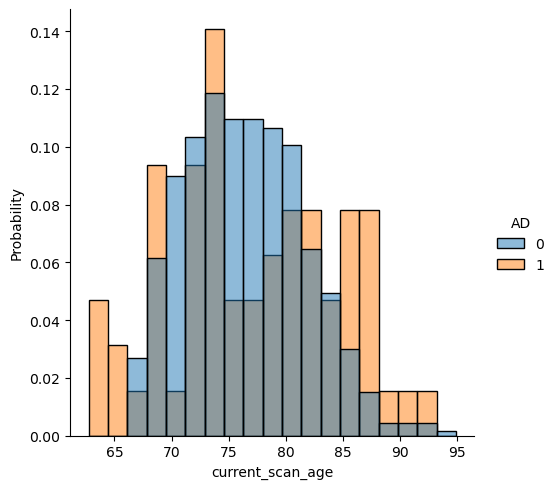

In [8]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    stat="probability",
    common_norm=False,
)
plt.show()

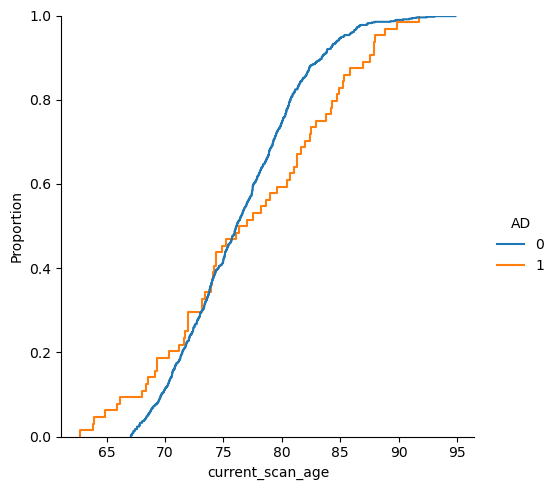

In [9]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    kind="ecdf",
)
plt.show()

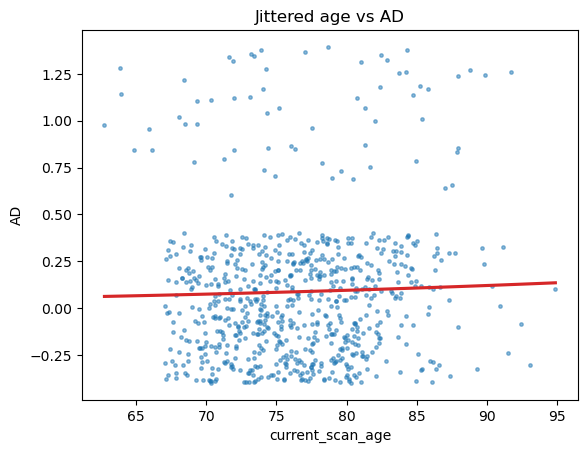

In [10]:
sns.regplot(
    df,
    x="current_scan_age", 
    y="AD",
    logistic=True,
    ci=None,
    line_kws={"color":"tab:red"}, 
    scatter_kws={"alpha": 0.5, "s":6},
    y_jitter=0.4,
)
plt.title("Jittered age vs AD")
plt.show()

### APOE allele

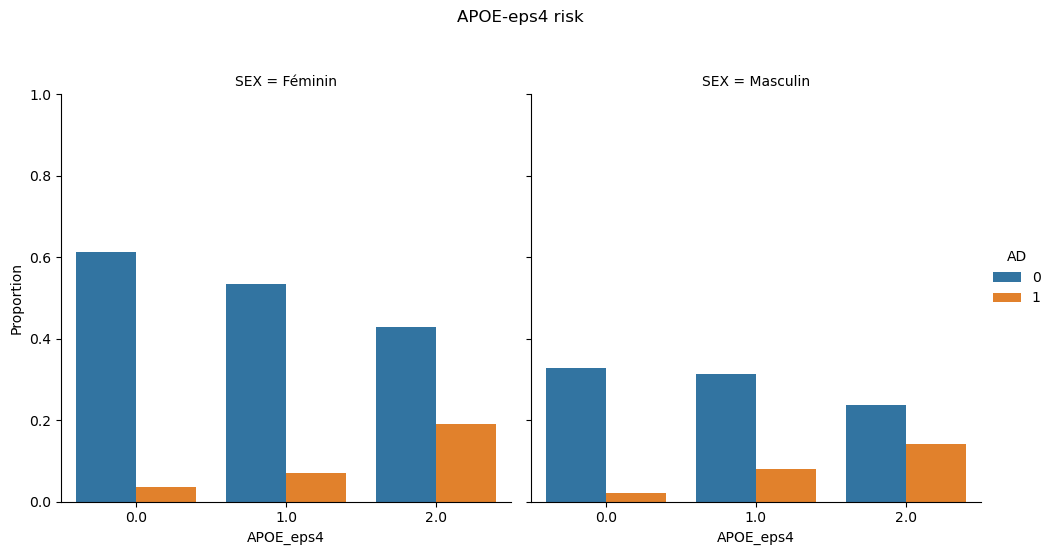

In [11]:
x, y = 'APOE_eps4', "AD"
f = (cleaned_df.groupby(x)[[y, "SEX"]]
.value_counts(normalize=True)
.rename('Proportion')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='Proportion',hue=y,kind='bar', col="SEX"))
plt.ylim(0, 1)
plt.suptitle("APOE-eps4 risk", y=1.1)
plt.show()

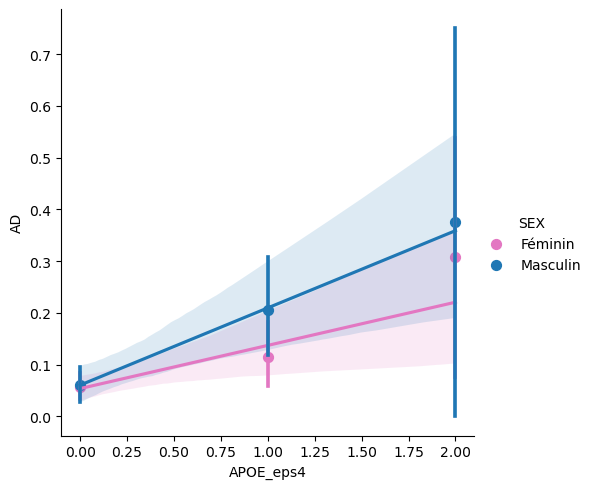

In [12]:
sns.lmplot(
    y="AD",
    x="APOE_eps4",
    data=cleaned_df,
    x_estimator=np.mean,
    #logistic=True,
    hue="SEX",
    palette=["tab:pink", "tab:blue"]
)
plt.show()

## Model fitting

In [13]:
df.columns

Index(['file_path', 'file_basename', 'file_tag', 'file_type', 'file_fields',
       'sub', 'ses', 'task', 'space', 'res',
       ...
       'R Ant IPS_Broca', 'R Ant IPS_Sup Front S', 'R Ant IPS_R TPJ',
       'R Ant IPS_R Pars Op', 'R Ant IPS_Cereb', 'R Ant IPS_Dors PCC',
       'R Ant IPS_L Ins', 'R Ant IPS_Cing', 'R Ant IPS_R Ins',
       'R Ant IPS_L Ant IPS'],
      dtype='object', length=774)

In [22]:
tst_edge_name = 'R Ant IPS_Cing'
lhs, rhs = model_matrix(f"`{tst_edge_name}` ~ AD", df)

In [25]:
import statsmodels.api as sm

model = sm.OLS(endog=lhs, exog=rhs)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         R Ant IPS_Cing   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.752
Date:                Wed, 28 Feb 2024   Prob (F-statistic):              0.186
Time:                        16:23:03   Log-Likelihood:                 121.58
No. Observations:                 731   AIC:                            -239.2
Df Residuals:                     729   BIC:                            -230.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3457      0.008     43.517      0.000       0.330       0.361
AD             0.0355      0.027      1.324      0.186      -0.017       0.088
==============================================================================
Omnibus:                        1.464   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.481   Jarque-Bera (JB):                1.366
Skew:                          -0.012   Prob(JB):                        0.505
Kurtosis:                       3.210   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# TODO Change name
def fit_edges(ROI_name, dataframe):
    lhs, rhs = model_matrix(f"`{ROI_name}` ~ AD + scale(current_scan_age) + SEX", dataframe)
    model = sm.OLS(endog=lhs, exog=rhs)
    result = model.fit()
    return result.params.AD, result.pvalues.AD
    

In [28]:
test_results = []
# TODO Parallelize
for edge in edges:
    test_results.append(fit_edges(edge, df))

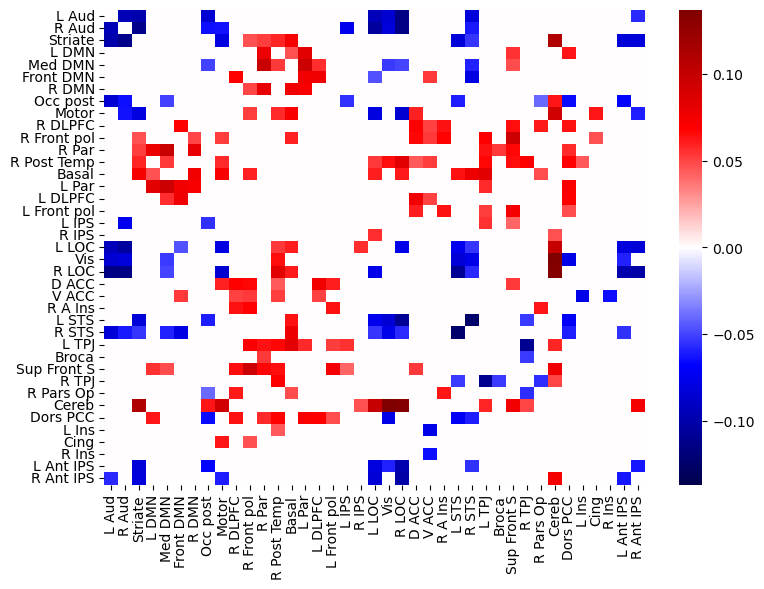

In [32]:
stats = [tr[0] for tr in test_results]
pvalues = [tr[1] for tr in test_results]
statmat = reshape_pvalues(stats)

pmat = reshape_pvalues(pvalues)
display_mat = np.where(pmat < config["alpha"], statmat, 0)

plot_matrix(display_mat, atlas=atlas)
plt.show()

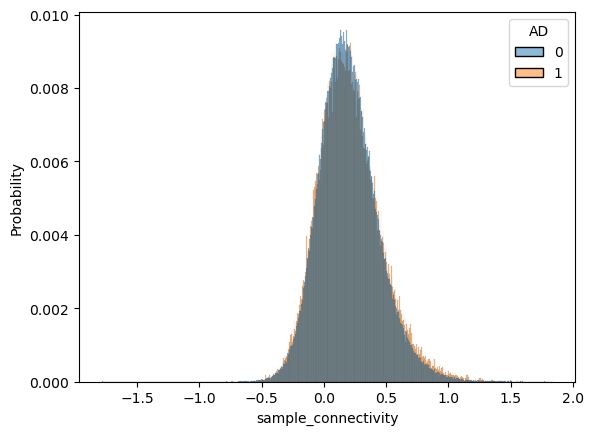

In [46]:
conn_AD = df[edges + ["AD"]]
m = conn_AD.melt(id_vars='AD', var_name="edge", value_name="sample_connectivity")
sns.histplot(m, x="sample_connectivity", hue="AD", stat="probability", common_norm=False)
plt.show()

### Assumptions on residuals

In [33]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(result)

#### Normality

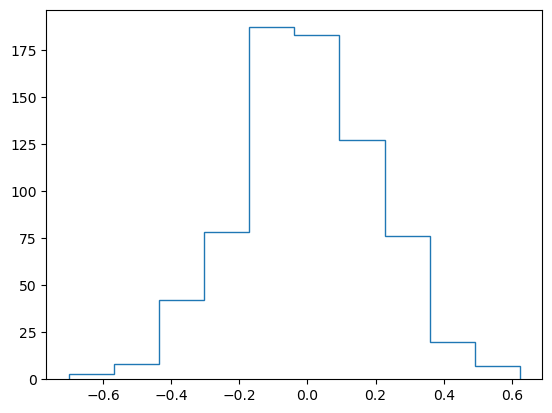

In [34]:
plt.hist(result.resid, histtype="step")
plt.show()

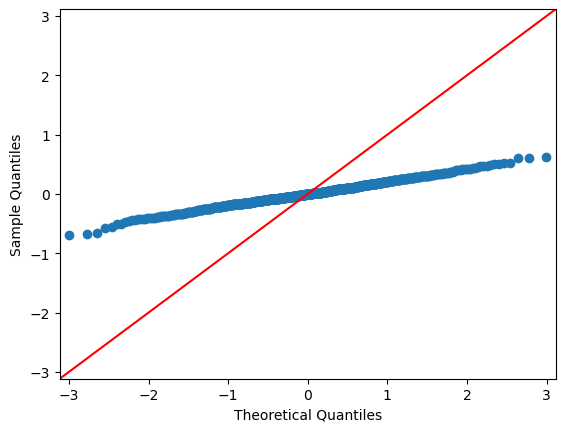

In [35]:
from statsmodels.graphics.gofplots import qqplot

qqplot(influence.resid, line="45")
plt.show()

#### Homoskedasticity

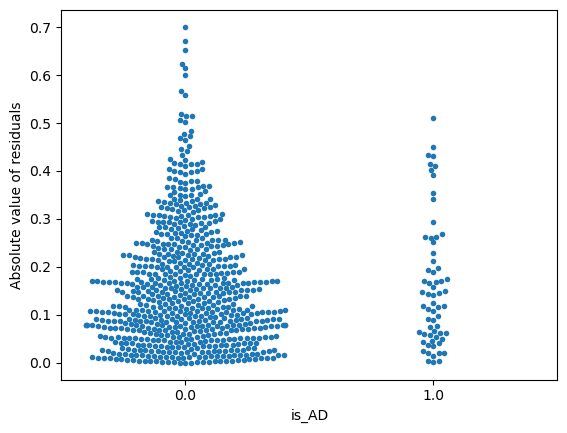

In [36]:
# Spread Location plot
sns.swarmplot(
    x=model.exog[:, 1],
    y=abs(result.resid),
    size=4
)
plt.xlabel("is_AD")
plt.ylabel("Absolute value of residuals")
plt.show()

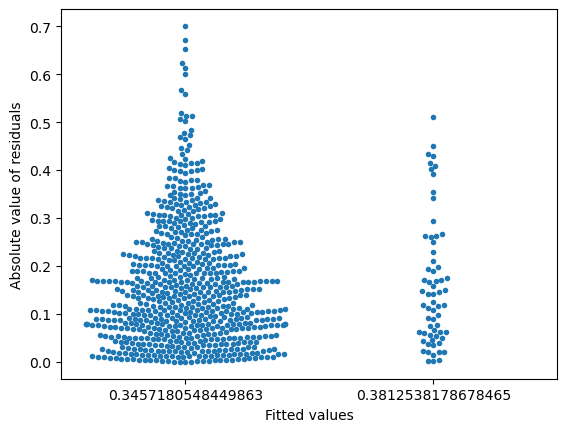

In [37]:
sns.swarmplot(
    x=result.fittedvalues,
    y=abs(result.resid),
    size=4
)
plt.xlabel("Fitted values")
plt.ylabel("Absolute value of residuals")
plt.show()

#### Linearity

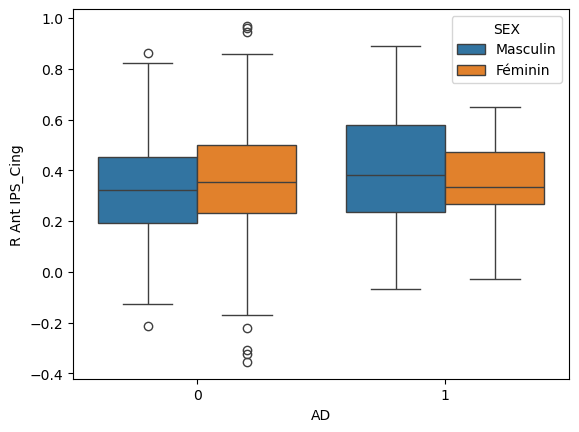

In [42]:
# Linearity holds for categorical features
sns.boxplot(
    df,
    x="AD",
    y=tst_edge_name,
    hue="SEX"
)
plt.show()